In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sys

In [2]:
cols  = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']
#sys.getdefaultencoding()

In [3]:
df = pd.read_csv('../dataset/training.1600000.processed.noemoticon.csv', header=None, names=cols, encoding='ISO-8859-1')

In [4]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [6]:
# Dropping unnecessary columns
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [7]:
#Data Preparation
df['pre_clean_len'] = [len(t) for t in df.text]

In [8]:
df.head()

,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [9]:
from pprint import pprint

#Data Dictionary

data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


<function matplotlib.pyplot.show>

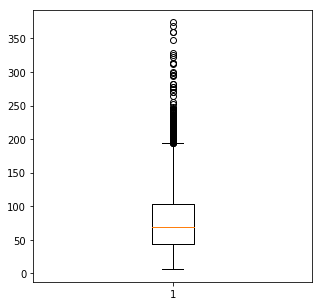

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show

In [11]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


In [12]:
from bs4 import BeautifulSoup
#Dealing with HTML Encoding
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [13]:
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())
# &amp --> &

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [14]:
#Dealing with @mention
import re
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [15]:
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [16]:
#Dealing with URLs
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [17]:
re.sub('https?://[A-Za-z0-0./]+','', df.text[0])

"@switchfoot 2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [18]:
# UTF-8 BOM
df.text[226]

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [19]:
#testing = df.text[226].decode("utf-8-sig")
#testing

In [20]:
#Dealing with Hashtags
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [21]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [22]:
#Data cleaning function
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters only process two lines above, it has created unnecessay white spaces,
    # Remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[:100]

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt

In [23]:
nums = [0,400000,800000,1200000,1600000]

In [24]:
%%time
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has

In [25]:
%%time
print ("Cleaning and parsing the tweets...\n")
for i in range(nums[1],nums[2]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[2] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 8

In [26]:
%%time
print ("Cleaning and parsing the tweets...\n")

for i in range(nums[2],nums[3]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[3] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been pro

In [27]:
%%time
print ("Cleaning and parsing the tweets...\n")
for i in range(nums[3],nums[4]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[4] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1

In [28]:
#Saving cleaned data as CSV
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [29]:
clean_df.to_csv('../dataset/clean_tweet.csv',encoding='utf-8')
csv = '../dataset/clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

/home/rajat/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [30]:
my_df.describe()

,target
count,1.600000e+06
mean,2.000000e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [31]:
my_df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [32]:
import pandas as pd
import numpy as np

In [33]:
df_clean = pd.read_csv('../dataset/clean_tweet.csv')
df_clean = df_clean.drop(df_clean.columns[[0]], axis=1)
df_clean.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [34]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [35]:
def tweet_to_words(phrase):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(phrase)
    
   # print(type(word_tokens))
    
    meaningful_words = [w for w in word_tokens if not w in stop_words]
    
    # print((meaningful_words))
    
    return (' '.join(meaningful_words))
    return(meaningful_words)

# textList[208]

In [36]:
#df_clean['meaningfulWords'] = df.apply(lambda _: '', axis=1)
#for phrase in df_clean['text']:
 #   df_clean['meaningfulWords'][phrase] = tweet_to_words(phrase)

In [37]:
type(df_clean['text'])  

pandas.core.series.Series

In [38]:
textList = df_clean['text']

In [39]:
textList[0]

'awww that s a bummer you shoulda got david carr of third day to do it d'

In [40]:
FilteredText = []
'''for i in range(textList.size):
    temp = textList[i]
    FilteredText.append(tweet_to_words(temp)) '''
FilteredText.append(tweet_to_words(textList[0]))
FilteredText.append(tweet_to_words(textList[1]))
FilteredText

['awww bummer shoulda got david carr third day',
 'upset update facebook texting might cry result school today also blah']

In [41]:
div = [0, 400000, 800000, 1200000, 1600000]
processedText = []

In [42]:
%%time

for i in range(div[0], div[1]):
    
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, div[1] ))
    
    temp = ''
    
    if (textList[i] is not np.nan):
        temp = tweet_to_words(textList[i])
        
    processedText.append(temp)   

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has been processed
Tweets 240000 of 400

In [43]:
%%time

for i in range(div[1], div[2]):
    
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, div[2] ))
    
    temp = ''
    
    if (textList[i] is not np.nan):
        temp = tweet_to_words(textList[i])
        
    processedText.append(temp)  

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 800000 has been processed
Tweets 6400

In [44]:
%%time

for i in range(div[2], div[3]):
    
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, div[3] ))
    
    temp = ''
    
    if (textList[i] is not np.nan):
        temp = tweet_to_words(textList[i])
        
    processedText.append(temp)  

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been processed
Tweets 1030000 of 1200000 has

In [45]:
%%time

for i in range(div[3], div[4]):
    
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, div[4] ))
    
    temp = ''
    
    if (textList[i] is not np.nan):
        temp = tweet_to_words(textList[i])
        
    processedText.append(temp)  

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1600000 has been processed
Tweets 143

In [46]:
len(processedText)

1600000